# Import packages

In [1]:
import os
import json
import numpy as np
from sympy import symbols, sympify, lambdify
from tabulate import tabulate
import yaml
from datetime import datetime
import glob
import matplotlib.pyplot as plt

import tensorflow as tf

tf.keras.backend.set_floatx('float64')

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


# Set random seeds for reproducibility
seed_value = 2023
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

# # Set random seed for GPU (if using TensorFlow with GPU)
# if tf.test.is_gpu_available():
#     tf.config.experimental.random_seed(seed_value)


## Allow to print actual tf values
# tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)

2023-12-21 11:28:17.607512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 11:28:18.691651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Constants and parameters

In [2]:
tf_precision = tf.float64
np_precision = np.float64

with open('config_run.yml', 'r') as ymlfile:
    config_data = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [3]:
problem_name = config_data['problem_folder']
EQS_FILE = problem_name + '.json'
EQS_PATH = os.path.join(os.getcwd(), problem_name, EQS_FILE)

training_steps = config_data['epochs']
display_step = training_steps // 20

load_initial_estimate = config_data['load_initial_estimate']
save_best_solution = config_data['save_best_solution']

lambda_regularization = float(config_data['lambda_regularization'])

if len(list(config_data['learning_rate'].keys())) > 1:
    lr_steps = [int(training_steps * key / 100) for key in list(config_data['learning_rate'].keys()) if key != 0]
    lr_values = [float(val) for val in list(config_data['learning_rate'].values())]
    learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(lr_steps, lr_values)
else:
    learning_rate = float(list(config_data['learning_rate'].values())[0])

In [4]:
# Read the JSON data from the file
with open(EQS_PATH, 'r') as file:
    data = json.load(file)

variables = data['variables']
equations = data['equations']
# equation_terms = data['equation_terms']

variables_str = ' '.join(variables)
variables_sym = symbols(variables_str)
equations_sym = [sympify(eq) for eq in equations]  

## Identify the equation terms
equation_terms = []
for (i, eq) in enumerate(equations_sym):
    terms = []
    for term in eq.args:
        terms.append(str(term))
    equation_terms.append(terms)

# Initialize a list to store the coefficients
scalar_coefficients = []
functions = []
bias_coefficients = []

# Loop through the equation terms
for terms in equation_terms:
    bias_coefficients.append(float(terms[0]))
    coefficients = []   
    for term in terms[1:]:
        # Split each term by the first '*'
        term_parts = term.split('*')
        # Extract the scalar coefficient or default to '1'
        scalar_coeff = term_parts[0] if len(term_parts) > 1 and term_parts[0] not in variables else '1.0'
        coefficients.append(float(scalar_coeff))
               
        # Remove first occurrence of scalar coefficient from the term
        func_coeff = term.replace(term_parts[0]+'*', '', 1) if len(term_parts) > 1 and term_parts[0] not in variables else term
        functions.append(func_coeff)
        
    scalar_coefficients.append(coefficients)   
       
functions_sym = [sympify(func) for func in functions]       
        
print(bias_coefficients)
print(scalar_coefficients)
print(functions)
print(functions_sym)
print(equations_sym)
print(f"Number of equations: {len(equations_sym)}")
print(f"Number of variables: {len(variables_sym)}")

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
[[1.0, 1.0, 1.0, 1.0], [2.0, 2.0, 2.0], [6.0, 6.0], [3.0, 3.0, 3.0], [24.0], [12.0, 12.0], [8.0, 8.0], [4.0, 4.0, 4.0]]
['b_1', 'b_2', 'b_3', 'b_4', 'a_21*b_2', 'b_3*(a_31 + a_32)', 'b_4*(a_41 + a_42 + a_43)', 'b_4*(a_21*a_42 + a_43*(a_31 + a_32))', 'a_21*a_32*b_3', 'a_21**2*b_2', 'b_3*(a_31 + a_32)**2', 'b_4*(a_41 + a_42 + a_43)**2', 'a_21*a_32*a_43*b_4', 'b_4*(a_21**2*a_42 + a_43*(a_31 + a_32)**2)', 'a_21**2*a_32*b_3', 'b_4*(a_21*a_42 + a_43*(a_31 + a_32))*(a_41 + a_42 + a_43)', 'a_21*a_32*b_3*(a_31 + a_32)', 'a_21**3*b_2', 'b_3*(a_31 + a_32)**3', 'b_4*(a_41 + a_42 + a_43)**3']
[b_1, b_2, b_3, b_4, a_21*b_2, b_3*(a_31 + a_32), b_4*(a_41 + a_42 + a_43), b_4*(a_21*a_42 + a_43*(a_31 + a_32)), a_21*a_32*b_3, a_21**2*b_2, b_3*(a_31 + a_32)**2, b_4*(a_41 + a_42 + a_43)**2, a_21*a_32*a_43*b_4, b_4*(a_21**2*a_42 + a_43*(a_31 + a_32)**2), a_21**2*a_32*b_3, b_4*(a_21*a_42 + a_43*(a_31 + a_32))*(a_41 + a_42 + a_43), a_21*a_32*b_3*(a_31 + a_32), a

# Functions

In [5]:
def load_most_recent_estimate(problem_name, prefix="best_estimate"):
    # Find all JSON files with the specified prefix
    pattern = os.path.join(problem_name, f"{prefix}_*.json")
    files = glob.glob(pattern)

    if not files:
        print(f"No files found with prefix '{prefix}'")
        return None

    # Get the most recent file based on modification time
    most_recent_file = max(files, key=os.path.getmtime)
    
    print(f"Loading most recent estimate from {most_recent_file}")

    # Load json file with initial estimate (best from the most recent run)
    with open(most_recent_file, 'r') as file:
        data = json.load(file)

    return data['best_solution']

@tf.autograph.experimental.do_not_convert
def evaluate_tf_function(inputs, values, symbolic_function):
    # Ensure that the number of inputs and values match
    if len(inputs) != len(values):
        raise ValueError("Number of inputs and values must match.")

    # Evaluate the symbolic function using TensorFlow and the provided values
    result = symbolic_function(*values)
    # Convert the result to a TensorFlow tensor
    result = tf.convert_to_tensor(result, dtype=tf_precision)
    
    # print(result.__class__)
    
    return result

# Create model
@tf.autograph.experimental.do_not_convert
def mlp_model(num_outputs, hidden_layers = [16, 16]):

    # # Reshape input if necessary, matching the shape of the first layer's weights
    # x = tf.reshape(x, [1, -1])  # Adjust the shape as needed
    
    mlp_input = Input(shape=(1,1), name="mlp_input")
    
    hidden_layer = mlp_input
    
    for li, layer_size in enumerate(hidden_layers):
        # Create hidden layer initialized with Glorot uniform
        hidden_layer = Dense(layer_size, activation='tanh', 
                             kernel_initializer='glorot_uniform',
                             kernel_regularizer=tf.keras.regularizers.l2(lambda_regularization),
                             name=f"hidden_layer_{li+1}")(hidden_layer)

    output_layer = Dense(num_outputs, activation='linear', 
                         kernel_initializer='glorot_uniform',
                         kernel_regularizer=tf.keras.regularizers.l2(lambda_regularization),
                         name="output_layer")(hidden_layer)
    
    return Model(inputs=mlp_input, outputs=output_layer)

@tf.autograph.experimental.do_not_convert
def customMSE(vars=variables_sym, funcs=equations_sym, lambda_reg=0.01):
    
    def mse(y_true, y_pred):
        
        y_pred_values = y_pred[0, 0, :]
        
        var_vals = [tf.squeeze(y_pred[0, 0, i]) for i in range(y_pred_values.shape[0])]
        
        nn_residual = list()
        for func in funcs:
            # print(f"func = {func}")
            func_tf = lambdify(vars, func, 'tensorflow')
            nn_residual.append(evaluate_tf_function(variables_sym, var_vals, func_tf))
        
        nn_residual_tf = tf.convert_to_tensor(nn_residual, dtype=tf_precision)

        mse_value = tf.reduce_mean(tf.square(nn_residual_tf))
        
        # Add regularization so the output is not all zeros
        nn_output = y_pred[0, 0, :]
        reg_value = tf.reduce_mean(tf.square(nn_output))        
        
        return mse_value  ##* (1.0 - lambda_reg) + reg_value * lambda_reg
        
        # return y_pred

    return mse


# Model

## Create and compile model

In [6]:
# Network Parameters
num_input = 1 # input layer

hidden_layers = config_data['hidden_layers']    ##[4, 8, 16]

num_vars = len(variables)
num_output = num_vars

# Create the model
model = mlp_model(num_output, hidden_layers = hidden_layers)
model.summary()

# Define the optimizer and loss function
optimizer = Adam(learning_rate=learning_rate)
# optimizer = SGD(learning_rate=learning_rate)
# optimizer = RMSprop(learning_rate=learning_rate)
loss_object = customMSE(variables_sym, equations_sym, lambda_reg=lambda_regularization)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_object)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mlp_input (InputLayer)      [(None, 1, 1)]            0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1, 16)             32        
                                                                 
 hidden_layer_2 (Dense)      (None, 1, 32)             544       
                                                                 
 output_layer (Dense)        (None, 1, 10)             330       
                                                                 
Total params: 906 (7.08 KB)
Trainable params: 906 (7.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-21 11:28:20.104642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44045 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6
2023-12-21 11:28:20.105502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46337 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


## Train the model

In [7]:
# Create a constant input (e.g., zeros) since the input is supposed to be constant
constant_input = np.ones((1, 1, 1))

# Assuming num_output is the number of output nodes in your model
# You can use a dummy value for y_true since your loss function doesn't depend on it
dummy_y_true = np.zeros((1, num_output))

# Fit the model
history = model.fit(x=constant_input, y=dummy_y_true, 
          epochs=training_steps, 
          batch_size=1,
          verbose=2)

Epoch 1/10000


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-12-21 11:28:42.174272: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f313dfb5550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 11:28:42.174353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-21 11:28:42.174368: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-12-21 11:28:42.184406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-21 11:28:42.205698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-21 11:28:42.422379: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 22s - loss: 4.8875 - 22s/epoch - 22s/step
Epoch 2/10000
1/1 - 0s - loss: 4.8394 - 13ms/epoch - 13ms/step
Epoch 3/10000
1/1 - 0s - loss: 4.7927 - 12ms/epoch - 12ms/step
Epoch 4/10000
1/1 - 0s - loss: 4.7475 - 14ms/epoch - 14ms/step
Epoch 5/10000
1/1 - 0s - loss: 4.7037 - 13ms/epoch - 13ms/step
Epoch 6/10000
1/1 - 0s - loss: 4.6612 - 14ms/epoch - 14ms/step
Epoch 7/10000
1/1 - 0s - loss: 4.6199 - 13ms/epoch - 13ms/step
Epoch 8/10000
1/1 - 0s - loss: 4.5798 - 14ms/epoch - 14ms/step
Epoch 9/10000
1/1 - 0s - loss: 4.5408 - 13ms/epoch - 13ms/step
Epoch 10/10000
1/1 - 0s - loss: 4.5028 - 12ms/epoch - 12ms/step
Epoch 11/10000
1/1 - 0s - loss: 4.4657 - 16ms/epoch - 16ms/step
Epoch 12/10000
1/1 - 0s - loss: 4.4295 - 13ms/epoch - 13ms/step
Epoch 13/10000
1/1 - 0s - loss: 4.3941 - 13ms/epoch - 13ms/step
Epoch 14/10000
1/1 - 0s - loss: 4.3595 - 12ms/epoch - 12ms/step
Epoch 15/10000
1/1 - 0s - loss: 4.3254 - 12ms/epoch - 12ms/step
Epoch 16/10000
1/1 - 0s - loss: 4.2920 - 13ms/epoch - 13ms/step


## Plot history

### Plot function

In [ ]:
def plot_training_history(history, rk_method, hidden_layers, optimizer_name, lr_plot, lambda_regularization):
    # Plot training history with log scale (left) and linear scale (right)
    plt.figure(figsize=(10, 5))

    # Plot on the right side with linear scale
    plt.plot(history.history['loss'], color='orange', label='Linear Scale')
    plt.title(f"Training history RK_{rk_method} {hidden_layers}-{optimizer_name}-{lr_plot}-{lambda_regularization}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Create a secondary y-axis for the right side
    plt2 = plt.gca().twinx()
    
    # Plot on the left side with log scale
    plt2.semilogy(history.history['loss'], label='Log Scale')
    plt2.set_ylabel('Loss (Log Scale)')
    
    # Find the minimum loss and epoch associated with the minimum loss
    min_loss = min(history.history['loss'])
    min_loss_epoch = history.history['loss'].index(min_loss) + 1
    # Plot the minimum loss as a red bold cross
    plt2.scatter(min_loss_epoch, min_loss, marker='X', color='red', s=80, label=f'Min Loss = {min_loss:.2e}')
    

    # Add legend for both axes
    plt.legend(loc='upper left')
    plt2.legend(loc='upper right')

    # Show the plot
    plt.show()

### Call plots

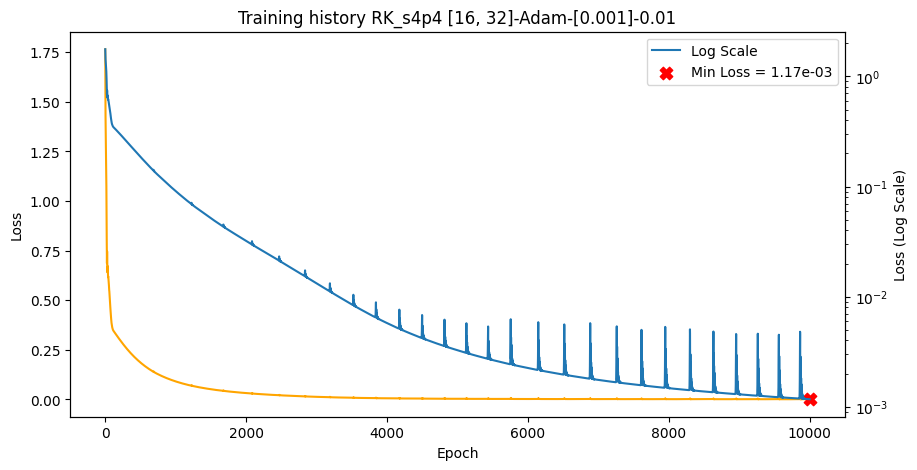

In [ ]:
lr_plot = [float(lr) for lr in list(config_data['learning_rate'].values())]
rk_method = problem_name.split('_')[-1]
optimizer_name = optimizer.__class__.__name__

plot_training_history(history, rk_method, hidden_layers, optimizer_name, lr_plot, lambda_regularization)

## Test the model

In [ ]:
# Test the model
solution = model.predict(constant_input)[0][0]

print('Solution:')
for i, var in enumerate(variables):
    print(f'{var:4} = {solution[i]:.16f}')

headers = ['Equation', 'Function residual']
table_data = []
for f, func in enumerate(equations):
    eq = equations_sym[f]
    equation = lambdify(variables_sym, eq)
    func_res_eq = abs(equation(*solution))
    table_data.append([f'{func} = ', f'{func_res_eq:.4e}'])

print(tabulate(table_data, headers=headers, tablefmt='grid'))

1/1 [==============================] - 0s 168ms/step


Solution:
a_21 = -1.0638581767813591
a_31 = -0.4981070724881103
a_32 = 0.0411955800118507
a_41 = 1.2180787023602468
a_42 = 0.2088089001789060
a_43 = -0.8705657506201059
b_1  = -0.4982828992070799
b_2  = -0.0926765210855483
b_3  = 0.4877819920087401
b_4  = 1.1031672592318802
+---------------------------------------------------------------------------------------------------+---------------------+
| Equation                                                                                          |   Function residual |
+===================================================================================================+=====================+
| b_1 + b_2 + b_3 + b_4 - 1 =                                                                       |          1.0169e-05 |
+---------------------------------------------------------------------------------------------------+---------------------+
| 2*a_21*b_2 + 2*b_3*(a_31 + a_32) + 2*b_4*(a_41 + a_42 + a_43) - 1 =                               |    

## Save the solution

In [ ]:
# Save solution to txt file in RK_solutions folder
save_folder = "RK_solutions"

filename = f"RK_{rk_method}_solution_v0.txt"
while os.path.exists(os.path.join(save_folder, filename)):
    # Find the last version number
    version = int(filename.split("_v")[-1].split(".")[0])
    # Increment version number
    version += 1
    # Replace version number in filename
    filename = filename.replace(f"_v{version-1}", f"_v{version}")
    
filepath = os.path.join(save_folder, filename) 

# Create and write to the file
with open(filepath, 'w') as file:
    file.write(f'{solution[0]:.32f}')
    for i in range(1, len(variables)):
        file.write(f'\n{solution[i]:.32f}')